In [1]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import pennylane as qml

alphabet = {"0":{"gate": qml.PauliX, "wires": [2]},
                    "1":{"gate": qml.RZ, "wires": [0]},
                    "2":{"gate": qml.RY, "wires": [1]},
                    "3":{"gate": qml.CNOT, "wires": [1,2]},#, "params":[np.pi]},
                    "4":{"gate": qml.CNOT, "wires": [1,0]},#, "params":[np.pi]},
                    "5":{"gate": qml.RY, "wires": [0]},
                    "6":{"gate":qml.Rot, "wires":[0]}, #borrowed from other optimization
                    "7":{"gate": qml.CNOT, "wires": [0,1]},#, "params":[np.pi]},
                   }

alphabet_cirq = {"0":{"gate": cirq.X, "wires": [2]},
                    "1":{"gate": cirq.rz, "wires": [0]},
                    "2":{"gate": cirq.ry, "wires": [1]},
                    "3":{"gate": cirq.CNOT, "wires": [1,2]},#, "params":[np.pi]},
                    "4":{"gate": cirq.CNOT, "wires": [1,0]},#, "params":[np.pi]},
                    "5":{"gate": cirq.ry, "wires": [0]},
                    "6":{"gate":cirq.rz, "wires":[0]},#optimal sequence will be larger..
                    "7":{"gate": cirq.CNOT, "wires": [0,1]},#, "params":[np.pi]},
                   }
parametrized = [cirq.rz, cirq.ry, cirq.rx]

In [2]:
class W_state:
    def __init__(self, qubits, trajectory):
        self.qubits = qubits
        param_ind=0
        gates=[]
        wires=[]
        params_cirquit=[]
        parhere=[]
        self.symbols=[]
        for gate_ind in trajectory:
            g = alphabet_cirq[str(int(gate_ind))]["gate"]
            wires.append(alphabet_cirq[str(int(gate_ind))]["wires"])
            if g in parametrized: #assuming is one qubit unitary
                symbol = "x_{}".format(param_ind)
                self.symbols.append(symbol)
                params_cirquit.append(sympy.Symbol(self.symbols[-1]))
                param_ind+=1
                gates.append(g(params_cirquit[-1]))
                parhere.append(True)
            else:
                gates.append(g)
                parhere.append(False)
        self.wires = wires
        self._gates=gates
        self.parhere =parhere
        self.circuit=self.get_state(qubits)

    def get_state(self, qubits, params=None):
        circuit = cirq.Circuit()
        cc=[]
        for ind, g in enumerate(self._gates):
            if len(self.wires[ind])==1:
                indqub = self.wires[ind][0]
                cc.append(g(qubits[indqub]))
            else:
                control, target = self.wires[ind]
                cc.append(g(qubits[control], qubits[target]))
        circuit.append(cc)
        if params is None:
            return circuit
        resolver = {k: v for k, v in zip(self.symbols, params)}
        return cirq.resolve_parameters(circuit, resolver)

In [3]:
qubits = cirq.GridQubit.rect(1, 3)
trajectory = np.array([0,1,2,3,4,5,4,6,5,6,7])
wst = W_state(qubits, trajectory)

sq = 1 / np.sqrt(3)
w_state = np.array([0, sq, sq, 0, sq, 0, 0, 0])
ww = cirq.density_matrix_from_state_vector(w_state)

In [33]:
PAULI_BASIS = {
    'I': np.eye(2),
    'X': np.array([[0., 1.], [1., 0.]]),
    'Y': np.array([[0., -1j], [1j, 0.]]),
    'Z': np.diag([1., -1]),
}

pauli3 = cirq.linalg.operator_spaces.kron_bases(PAULI_BASIS, repeat=3)
decomp = cirq.linalg.operator_spaces.expand_matrix_in_orthogonal_basis(ww, pauli3) #notice it's not required to be orthonormal!

PAULI_BASIS_CIRQ = {
    'I': cirq.X,
    'X': cirq.X,
    'Y': cirq.Y,
    'Z': cirq.Z,
}

unt = []
for term in decomp.items():
    gate_name = term[0]
    coeff = term[1]
    s=0
    ot=float(coeff)
    for qpos, single_gate in enumerate(gate_name):
        if single_gate == "I":
            ot*=PAULI_BASIS_CIRQ[single_gate](qubits[qpos])*PAULI_BASIS_CIRQ[single_gate](qubits[qpos])
        else:
            ot*=PAULI_BASIS_CIRQ[single_gate](qubits[qpos])
    if s<3:
        unt.append(ot)

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


In [35]:
len(alphabet_cirq)

8

In [8]:
def w_keras_model(wst, observable):
    # Construct measurement layers.
    circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
    output = tfq.layers.Expectation()(
            circuit_input,
            symbol_names=wst.symbols,
            operators=tfq.convert_to_tensor([observable]),
            initializer=tf.keras.initializers.RandomNormal())

    output = tf.math.reduce_sum(output, axis=-1, keepdims=True)

    model = tf.keras.Model(inputs=circuit_input, outputs=output)
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=adam, loss='mse')
    return model

model = w_keras_model(wst, unt)

In [9]:
w_input = tfq.convert_to_tensor([wst.circuit])
w_output = tf.ones((1,1))

In [12]:
history = model.fit(x=w_input, y=w_output, batch_size=1, epochs=10**4,
                    verbose=0)

In [13]:
float(np.squeeze(model.predict(w_input)))

0.9994077086448669

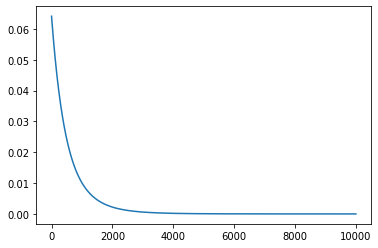

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])


In [15]:
ucirq = cirq.unitary(wst.get_state(qubits, model.get_weights()[0]))

In [16]:
np.abs(ucirq[:,0])**2

array([0.00000000e+00, 3.56459147e-01, 3.21778815e-01, 0.00000000e+00,
       3.21761847e-01, 0.00000000e+00, 0.00000000e+00, 1.90529256e-07])

In [17]:
np.dot(np.dot(ucirq[:,0], nn), np.conjugate(np.transpose(ucirq)[0])) #mean value of W! (fidelity with W-state!)

(0.999407950883274+0j)

In [18]:
np.abs(np.dot(ucirq[:,0], w_state))**2

0.9994079508832742

In [23]:
w_state**2

array([0.        , 0.33333333, 0.33333333, 0.        , 0.33333333,
       0.        , 0.        , 0.        ])

In [24]:
simulator = cirq.Simulator()
result = simulator.simulate(wst.get_state(qubits,params=model.get_weights()[0]), qubit_order=qubits)
np.abs(result.final_state)**2

array([0.0000000e+00, 3.5645911e-01, 3.2177880e-01, 0.0000000e+00,
       3.2176182e-01, 0.0000000e+00, 0.0000000e+00, 1.9051683e-07],
      dtype=float32)